In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
print("Current working directory is: ", os.getcwd())

Current working directory is:  /home/aabker/mlops/model-development


Read DataFrame

In [3]:
df = pd.read_csv("datasets/traffic.csv")

Explore Dataset

In [4]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,Rush Hour,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,1,5545
1,NaN,289.36,0.0,0.0,75,Clouds,0,4516
2,NaN,289.58,0.0,0.0,90,Clouds,0,4767
3,NaN,290.13,0.0,0.0,90,Clouds,0,5026
4,NaN,291.14,0.0,0.0,75,Clouds,0,4918


In [5]:
df.isnull().sum()

holiday           48143
temp                  0
rain_1h               0
snow_1h               0
clouds_all            0
weather_main          0
Rush Hour             0
traffic_volume        0
dtype: int64

In [6]:
df.dtypes

holiday            object
temp              float64
rain_1h           float64
snow_1h           float64
clouds_all          int64
weather_main       object
Rush Hour           int64
traffic_volume      int64
dtype: object

In [7]:
num_cols = [col for col in df.columns if df[col].dtype != 'object']
print("Numerical columns: ", num_cols)
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
print("Categorical columns: ", cat_cols)


Numerical columns:  ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'Rush Hour', 'traffic_volume']
Categorical columns:  ['holiday', 'weather_main']


In [8]:
#Explore categorical columns

for col in cat_cols:
    print(f"Unique values for {col} column: ", df[col].unique())

Unique values for holiday column:  [nan 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
Unique values for weather_main column:  ['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke']


In [9]:
#describe numerical columns
df[num_cols].describe()

,temp,rain_1h,snow_1h,clouds_all,Rush Hour,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,0.250124,3259.818355
std,13.338232,44.789133,0.008168,39.015750,0.433089,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,0.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,0.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,1.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,1.000000,7280.000000


In [10]:
df[cat_cols].describe()

,holiday,weather_main
count,61,48204
unique,11,11
top,Labor Day,Clouds
freq,7,15164


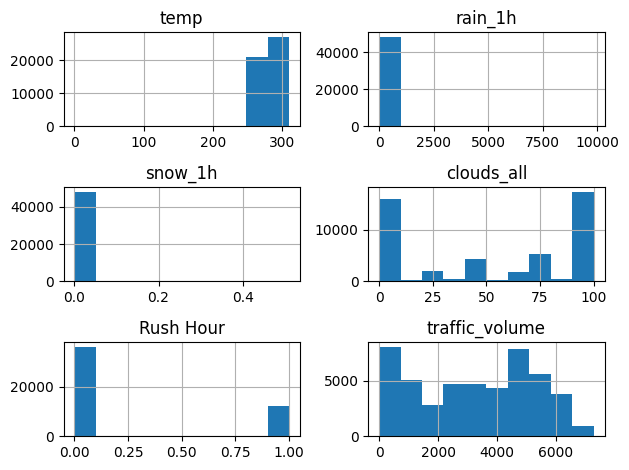

In [11]:
#Visually checking the data distribution for numerical columns
df[num_cols].hist()
plt.tight_layout()
plt.show()

Feature Engineering

In [12]:
#We can drop holiday column as it has too many missing values
df = df.drop('holiday', axis = 1)
df.shape

(48204, 7)

In [13]:
# df = pd.get_dummies(df, columns = ['weather_main'], prefix = 'weather')
# dummy_cols = [col for col in df.columns if 'weather' in col]
# df[dummy_cols] = df[dummy_cols].astype(int)

In [14]:
df.head(1)

,temp,rain_1h,snow_1h,clouds_all,weather_main,Rush Hour,traffic_volume
0,288.28,0.0,0.0,40,Clouds,1,5545


I suggest using a mapping that reflects the inherent pleasantness of each weather condition
In this mapping, lower values represent more pleasant conditions, and higher values represent less desirable or more extreme conditions. This should help the algorithm better understand the intended ranking of weather conditions based on their pleasantness.

In [15]:
dct_map = {
            'Clear': 1,
            'Clouds': 2,
            'Drizzle': 3,
            'Mist': 4,
            'Rain': 5,
            'Haze': 6,
            'Fog': 7,
            'Thunderstorm': 8,
            'Snow': 9,
            'Squall': 10,
            'Smoke': 11
        }

In [16]:
df['weather_main'] = df['weather_main'].map(dct_map)
df['weather_main'] = df['weather_main'].astype(int)

In [17]:
df.dtypes

temp              float64
rain_1h           float64
snow_1h           float64
clouds_all          int64
weather_main        int64
Rush Hour           int64
traffic_volume      int64
dtype: object

Features Selection

In [18]:
corr_matrix = df.corr(numeric_only = True)
corr_matrix["traffic_volume"].sort_values(ascending=False)

traffic_volume    1.000000
Rush Hour         0.339934
temp              0.130299
clouds_all        0.067054
rain_1h           0.004714
snow_1h           0.000733
weather_main     -0.035761
Name: traffic_volume, dtype: float64

Features correlation looks low in general with the target column, we may expect low model performance

In [19]:
X = df.drop('traffic_volume', axis = 1)
y = df['traffic_volume']

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestFeatures =  SelectKBest(score_func=chi2, k='all')
bestFeatures_Model = bestFeatures.fit(X,y)

dfscores = pd.DataFrame(bestFeatures_Model.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Scores']

featureScores.Scores = featureScores.Scores.apply(lambda x: f'{x:.2f}')
featureScores.sort_values(ascending=False, by= 'Scores')

,Specs,Scores
0,temp,5901.96
2,snow_1h,3998.25
1,rain_1h,32151933.55
3,clouds_all,290168.01
4,weather_main,14631.63
5,Rush Hour,12552.78


I will consider all features to use for modeling

Model Selection

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [22]:
len(X_train),  len(X_val), len(X_test)

(30850, 7713, 9641)

In [23]:
dv = DictVectorizer()

X_train_dicts = X_train.to_dict(orient= 'records')
X_val_dicts = X_val.to_dict(orient= 'records')
X_test_dicts = X_test.to_dict(orient= 'records')

X_train = dv.fit_transform(X_train_dicts)
X_val = dv.transform(X_val_dicts)
X_test = dv.transform(X_test_dicts)

In [24]:
# Initialize MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

scaler_x = MaxAbsScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_val_scaled = scaler_x.transform(X_val)
X_test_scaled = scaler_x.transform(X_test)

In [25]:
scaler_y = MaxAbsScaler()

y_train = y_train.values.reshape(-1, 1) # Reshape y to be a column vector
y_val = y_val.values.reshape(-1, 1) # Reshape y to be a column vector
y_test = y_test.values.reshape(-1, 1) # Reshape y to be a column vector

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

In [26]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train_scaled)

LinearRegression()

In [27]:
y_pred = lr.predict(X_train_scaled)
rmse = mean_squared_error(y_train_scaled, y_pred, squared= False)
print(f"train data, rmse is: {rmse:.4f}")

train data, rmse is: 0.2536


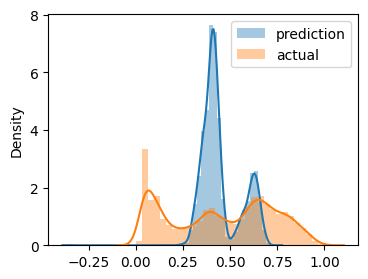

In [28]:
plt.figure(figsize=(4,3))
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train_scaled, label='actual')
plt.legend()
plt.show()

In [29]:
y_pred = lr.predict(X_val_scaled)
rmse = mean_squared_error(y_val_scaled, y_pred, squared= False)
print(f"validation data, rmse is: {rmse:.4f}")

validation data, rmse is: 0.2537


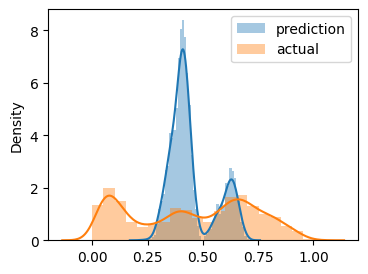

In [33]:
plt.figure(figsize=(4,3))
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val_scaled, label='actual')
plt.legend()
plt.show()

In [31]:
# to retransform the actuall target values

actual_predictions = scaler_y.inverse_transform(y_pred)
actual_predictions[:5]

array([[4643.80575058],
       [3227.47358379],
       [4552.95473619],
       [2868.7166574 ],
       [3044.76622103]])

Save Model

In [32]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, scaler_x, scaler_y, lr), f_out)